# <center>Regularization in Neural Network</center>
<center>Shan-Hung Wu & DataLab<br/>Fall 2016</center>

In [3]:
from IPython.display import Image
from IPython.display import display

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *

Deep neural network with a large number of parameters is a powerful machine learning system, but over-fitting is a serious issues in such networks. Deep neural network contains many non-linear hidden units and thus they can express very complicated relationships between their inputs and outputs. With limited training data, many of these relationships will be the result of sampling noise, so these relationships exist only on the training dataset, but not on the testing dataset. Large networks are slow, so it's hard for us to deal with the over-fitting issues by training several networks with different architecture and combine their outputs.
In this lab, we are going to talk about regularization in neural network.
We will introduce some common regularization methods in deep neural network today, which is 
* Dropout
* Weight decay
* Maxout
* Noise

We will use the CIFAR-10 dataset today for our experiment. [CIFAR-10]() is a object recognition dataset of 10 class. The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 


The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Here are the classes in the dataset, as well as 10 random images from each:
<img src="fig-cifar-10.png" width="400">



# Loading and Preprocess the CIFAR-10 Dataset

## Load Data
Set the path for storing the dataset on your machine.

In [11]:
import os
import numpy as np
import sys
import tarfile
import urllib.request
import pickle
import _pickle as cPickle
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from os.path import expanduser
home = expanduser('~')
data_path = os.path.join(home, "data/CIFAR-10/")

Using Theano backend.


AttributeError: module 'theano' has no attribute 'tests'

Set the constants for processing the dataset.

In [5]:
# the width and height of thes image
img_size = 32
# number of channels: red, green and blue
img_channels = 3
# number of classes
nb_classes = 10
# the width and height of out image
img_size = 32
# length of the image after we flatten the image into a 1-dim array
img_size_flat = img_size * img_size * img_channels
# number of classes
nb_classes = 10
# number of files in the training dataset
nb_files_train = 5
# number of images for each batch-file in the training-set.
images_per_file = 10000
# number of all the images in the training dataset
nb_images_train = nb_files_train * images_per_file


In [6]:
def download_cifar():
    # filename for saving the file downloaded from the internet.
    filename = 'cifar-10-batches-py/'
    file_path = os.path.join(data_path, filename)

    # if the file exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # check if the download directory exists, otherwise create it.
        if not os.path.exists(data_path):
            os.makedirs(data_path)

        # download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=data_url,
                                                  filename=os.path.join(data_path, 'cifar-10-python.tar.gz'),
                                                  reporthook=_print_download_progress)
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has already been downloaded and unpacked.")

In [7]:
def load_cifar():
    def load_data(file_name):
        """
        Load a pickled data-file from the CIFAR-10 data-set
        and return the converted and the class-number
        for each image.
        """

        file_path = os.path.join(data_path, "cifar-10-batches-py/", file_name)

        print("Loading data: " + file_path)

        with open(file_path, mode='rb') as file:    
            data = pickle.load(file, encoding='bytes')

        raw_images = data[b'data']

        # get the class-numbers for each image. Convert to numpy-array.
        cls = np.array(data[b'labels'])

        # convert the raw images from the data-files to floating-points.
        raw_float = np.array(raw_images, dtype=float) / 255.0

        # reshape the array to a 4-dim array with shape: [image_number, channel, height, width] where the pixels are floats between 0.0 and 1.0.
        images = raw_float.reshape([-1, img_channels, img_size, img_size])

        return images, cls

    def load_training_data():
        """
        Load all the training-data for the CIFAR-10 data-set.
        The data-set is split into 5 data-files which are merged here.
        Returns the images, class-numbers and one-hot encoded class-labels.
        """

        # pre-allocate the arrays for the images and class-numbers for efficiency.
        images = np.zeros(shape=[nb_images_train, img_channels, img_size, img_size], dtype=float)
        cls = np.zeros(shape=[nb_images_train], dtype=int)

        # begin-index for the current batch.
        begin = 0

        for i in range(nb_files_train):

            images_batch, cls_batch = load_data(file_name="data_batch_" + str(i + 1))
            num_images = len(images_batch)

            # End-index for the current batch.
            end = begin + num_images

            # store the images and class-numbers into the array.
            images[begin:end, :] = images_batch
            cls[begin:end] = cls_batch

            # The begin-index for the next batch is the current end-index.
            begin = end

        return images, cls, np_utils.to_categorical(cls, nb_classes)

    def load_test_data():
        """
        Load all the test-data for the CIFAR-10 data-set.
        Returns the images, class-numbers and one-hot encoded class-labels.
        """

        images, cls = load_data(file_name="test_batch")

        return images, cls, np_utils.to_categorical(cls, nb_classes)
    download_cifar()
    X_train, cls_train, y_train = load_training_data()
    X_test, cls_test, y_test = load_test_data()

    # split out validation dataset from training dataset
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [8]:
X_train, X_valid, X_test, y_train, y_valid, y_test= load_cifar()

NameError: name 'data_path' is not defined

Load the classes name in the CIFAR-10 dataset from the metafile.

In [35]:
import pickle

file_path = os.path.join(data_path, "cifar-10-batches-py/", "batches.meta")

print("Loading data: " + file_path)
# b means open file in binary mode
with open(file_path, mode='rb') as file:
    # remember to set the encoding of th file
    data = pickle.load(file, encoding='bytes')

raw = data[b'label_names']

# convert from binary strings.
class_names = [x.decode('utf-8') for x in raw]
# class_names a list with the names.
class_names

Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Load the testing dataset using similar method

Print out the size of the training and testing set to check if everything is loaded correctly.

In [36]:
# check data
print("Size of:")
print("- Training-set:\t\t{}".format(len(X_train)))
print("- Validation-set:\t{}".format(len(X_valid)))
print("- Test-set:\t\t{}".format(len(X_test)))

Size of:
- Training-set:		40000
- Validation-set:	10000
- Test-set:		10000


Let's use a deeper model to deal with the task today.

In [14]:
# here are some settings for the network
batch_size = 32
nb_epoch = 25

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.constraints import maxnorm
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time

# here are some settings for the network



model = Sequential()

model.add(Flatten(input_shape=(3, 32, 32)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))


# output layer
model.add(Dense(nb_classes, activation='softmax'))

# compile model
lrate = 0.01
decay = lrate/nb_epoch
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# this is a useful function for inspecting the output shape and the number of parameter of the model
print(model.summary())

start = time.time()
his = model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_4 (Flatten)              (None, 3072)          0           flatten_input_4[0][0]            
____________________________________________________________________________________________________
dense_20 (Dense)                 (None, 1024)          3146752     flatten_4[0][0]                  
____________________________________________________________________________________________________
dense_21 (Dense)                 (None, 1024)          1049600     dense_20[0][0]                   
____________________________________________________________________________________________________
dense_22 (Dense)                 (None, 1024)          1049600     dense_21[0][0]                   
___________________________________________________________________________________________

KeyboardInterrupt: 

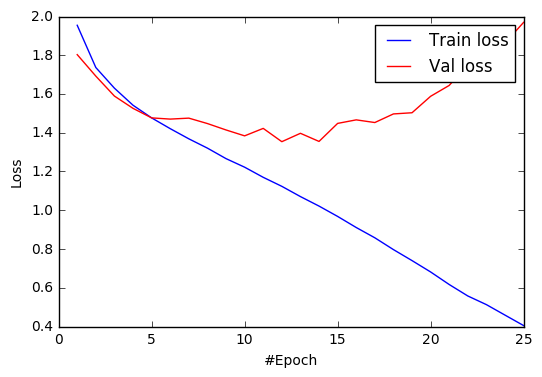

In [178]:
plot_validation_history(his, './output/fig-noconv-val-baseline.png')

Apparently we are having the issues of over fitting here. It's a chance for us to learn some regularizations technique.

# Dropout
Dropout is designed by Geoffrey Hinton.
The key idea is to randomly drop some units from the neural network during training, so that the neuron have to function well on its own instead of relying on other neurons. (Just like when you know your teammate is not that reliable, you have to take more responsibility)
In a standard neural network, the derivative received by each parameter tells it how it should change so the final loss function is reduced, given what all other units are doing. Therefore, units may change in a way that they fix up the mistakes of the other units. This may lead to complex co-adaptations.
Applying dropout to a neural network amounts to sampling a “thinned” network from it. The thinned network consists of all the units that are not dropped out (Figure b). A neural net with $n$ units, can be seen as a collection of  possible thinned neural networks. For each presentation of each training case, a new thinned network is sampled and trained.

The following figures illustrate the architecture:

<img src="fig-dropout.png" width="600">
<img src="fig-ensemble-of-subnetworks.png" width="600">


The choice of which units to drop is random. In the simplest case, each unit is retained with a fixed probability $p$ independent of other units, where $p$ can be chosen using a validation set or can simply be set at 0.5, which seems to be close to optimal for a wide range of networks and tasks.
At test time, it is not feasible to explicitly average the predictions from exponentially many thinned models. A very simple approximate averaging method works well in practice. The idea is to use a single neural net at test time **without dropout**. If a unit is retained with probability $p$ during training, the outgoing weights of that unit are multiplied by $p$ at test time as shown in the figure below. This is to ensure that for any hidden unit the expected output (under the distribution used to drop units at training time) is the same as the actual output at test time.
<img src="fig-weight.png" width="600">

Let's wrap our code into a function with several kinds of regularization options.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.constraints import maxnorm
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time

# monitor the validation loss
# min_delta : minimum change in the monitored quantity to qualify as an improvement
# patience : number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0)

def gen_nn(dropout=False, maxout=False, weight_constraint=False, l2_reg=False, l2_coef=0.1, l1_reg=False, l1_coef=0.005, batch_normalization=False):
    """
    Create a model according to the specification.
    """
    # here are some settings for the network   
    
    model = Sequential()
    model.add(Flatten(input_shape=(3, 32, 32))) 
    
    # we can think of this chunk as the hidden layer  
    if l2_reg:
        model.add(Dense(1024, W_regularizer=l2(l2_coef)))       
    else:
        model.add(Dense(1024))
        
    if batch_normalization:
        model.add(BatchNormalization(mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))
    
    model.add(Activation('relu'))
    # end of a hidden layer
    if dropout:
        model.add(Dropout(0.25))
        
    if l2_reg:
        model.add(Dense(1024, W_regularizer=l2(l2_coef)))          
    else:
        model.add(Dense(1024))

    # if batch_normalization:
      #  model.add(BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))
    
    model.add(Activation('relu'))
    
    if dropout:
        model.add(Dropout(0.25))
        
    if l2_reg:
        model.add(Dense(1024, W_regularizer=l2(l2_coef)))  
    elif maxout:
        model.add(MaxoutDense(1024*4, nb_feature=4, init='glorot_uniform'))
    else:
        model.add(Dense(1024))

    if batch_normalization:
        model.add(BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))
  
    model.add(Activation('relu'))
    
    if dropout:
        model.add(Dropout(0.25))
        
    if l2_reg:
        model.add(Dense(1024, W_regularizer=l2(l2_coef)))  
    else:
        model.add(Dense(1024))
  
    # if batch_normalization:
      #   model.add(BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))

    model.add(Activation('relu'))
    
    if dropout:    
        model.add(Dropout(0.25))
        
    if l2_reg:
        model.add(Dense(1024, W_regularizer=l2(l2_coef)))  
    elif maxout:
        model.add(MaxoutDense(1024*4, nb_feature=4, init='glorot_uniform'))
    else:
        model.add(Dense(1024))
 
    if batch_normalization:
        model.add(BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))
    
    model.add(Activation('relu'))      
    
    if l2_reg:
        model.add(Dense(1024, W_regularizer=l2(l2_coef)))  
    else:
        model.add(Dense(1024))
 
    # if batch_normalization:
      #   model.add(BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))
     
    model.add(Activation('relu'))
        
    if l2_reg:
        model.add(Dense(512, W_regularizer=l2(l2_coef)))  
    elif maxout:
        model.add(MaxoutDense(512*4, nb_feature=4, init='glorot_uniform'))
    else:
        model.add(Dense(512))
  
    if batch_normalization:
        model.add(BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))

    model.add(Activation('relu'))
        
        
    if l2_reg:
        model.add(Dense(512, W_regularizer=l2(l2_coef)))  
    elif maxout:
        model.add(MaxoutDense(512*4, nb_feature=4, init='glorot_uniform'))
    else:
        model.add(Dense(512))
 
    # if batch_normalization:
      #  model.add(BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))

    model.add(Activation('relu'))
        
    if l2_reg:
        model.add(Dense(512, W_regularizer=l2(l2_coef)))          
    elif maxout:
        model.add(MaxoutDense(512*4, nb_feature=4, init='glorot_uniform'))
    else:
        model.add(Dense(512))
        
    if batch_normalization:
        model.add(BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))        
    
    model.add(Activation('relu'))

    model.add(Dense(nb_classes, activation='softmax'))
    # compile model
    lrate = 0.01
    decay = lrate/nb_epoch
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

Using Theano backend.
ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device 0 failed:
initCnmem: cnmemInit call failed! Reason=CNMEM_STATUS_OUT_OF_MEMORY. numdev=1

ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device gpu failed:
initCnmem: cnmemInit call failed! Reason=CNMEM_STATUS_OUT_OF_MEMORY. numdev=1



RuntimeError: ('initCnmem: cnmemInit call failed! Reason=CNMEM_STATUS_OUT_OF_MEMORY. numdev=1\n', 'You asked to force this device and it failed. No fallback to the cpu or other gpu device.')

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.constraints import maxnorm
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time

# monitor the validation loss
# min_delta : minimum change in the monitored quantity to qualify as an improvement
# patience : number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0)

def gen_nn_2(nb_layers=16, dropout=False, maxout=False, weight_constraint=False, l2_reg=False, l2_coef=0.1, l1_reg=False, l1_coef=0.005, batch_normalization=False):
    """
    Create a model according to the specification.
    """
    # here are some settings for the network   
    
    model = Sequential()
    model.add(Flatten(input_shape=(3, 32, 32))) 
    
    for i in (1, nb_layers):
        
        # we can think of this chunk as the hidden layer  
        if l2_reg:
            model.add(Dense(1024, W_regularizer=l2(l2_coef))) 
        elif maxout and (i%4==0):
            model.add(MaxoutDense(1024*4, nb_feature=4, init='glorot_uniform'))            
        else:
            model.add(Dense(1024))

        if batch_normalization and (i%4==0):
            model.add(BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))

        model.add(Activation('relu'))
        # end of a hidden layer
        if dropout:
            model.add(Dropout(0.25))
        

    model.add(Dense(nb_classes, activation='softmax'))
    # compile model
    lrate = 0.01
    decay = lrate/nb_epoch
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

Using Theano backend.


AttributeError: module 'theano' has no attribute 'tests'


Training time: 100.468648 sec

Test loss: 1.312
Test accuracy: 0.545


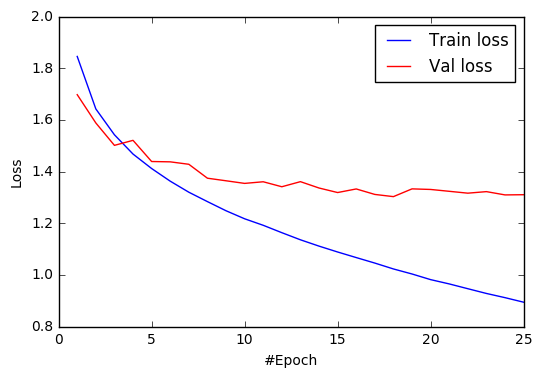

In [18]:
base_model = gen_nn_2()
start = time.time()
base_his = base_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          callbacks=[early_stop],
          verbose=0, 
          shuffle=True) \

# evaluate our model
score = base_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(base_his , './output/fig-nn-val-deep.png')


Training time: 277.747262 sec

Test loss: 1.396
Test accuracy: 0.513


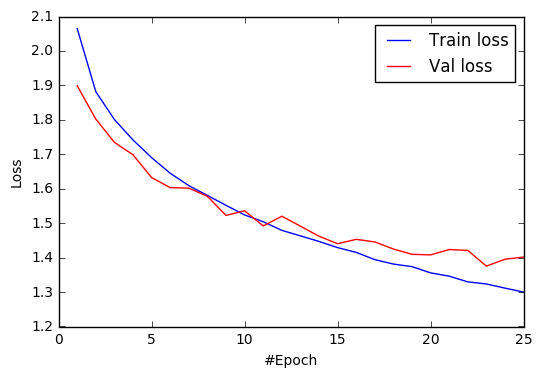

In [52]:
dropout_model = gen_nn(dropout=True)
start = time.time()
dropout_his = dropout_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          callbacks=[early_stop],
          verbose=0, 
          shuffle=True) \

# evaluate our model
score = dropout_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(dropout_his , './output/fig-nn-val-dropout.png')

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 4s - loss: 1.9704 - acc: 0.2799 - val_loss: 1.8142 - val_acc: 0.3442
Epoch 2/25
40000/40000 [==============================] - 4s - loss: 1.7980 - acc: 0.3515 - val_loss: 1.6932 - val_acc: 0.3899
Epoch 3/25
40000/40000 [==============================] - 4s - loss: 1.7101 - acc: 0.3861 - val_loss: 1.6438 - val_acc: 0.4104
Epoch 4/25
40000/40000 [==============================] - 4s - loss: 1.6541 - acc: 0.4045 - val_loss: 1.5722 - val_acc: 0.4373
Epoch 5/25
40000/40000 [==============================] - 4s - loss: 1.6162 - acc: 0.4207 - val_loss: 1.5368 - val_acc: 0.4497
Epoch 6/25
40000/40000 [==============================] - 4s - loss: 1.5827 - acc: 0.4329 - val_loss: 1.5260 - val_acc: 0.4495
Epoch 7/25
40000/40000 [==============================] - 4s - loss: 1.5521 - acc: 0.4468 - val_loss: 1.5070 - val_acc: 0.4699
Epoch 8/25
40000/40000 [==============================] - 4s 

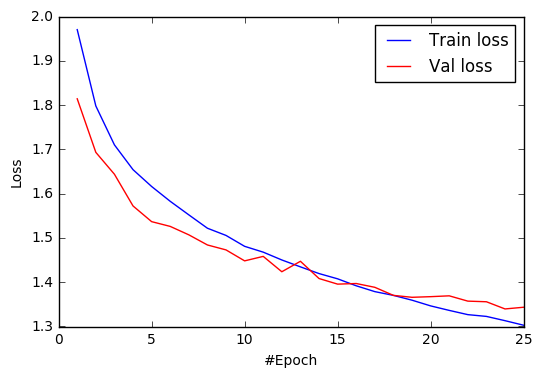

In [17]:
dropout_model = gen_nn_2(dropout=True)
start = time.time()
dropout_his = dropout_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          callbacks=[early_stop],
          verbose=0, 
          shuffle=True) \

# evaluate our model
score = dropout_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(dropout_his , './output/fig-nn-val-dropout.png')

We can see the dropout has a signifanct effect on the result!

# Weight Decay
If you recall we talked about weight decay before. We can penalize large weights using penalties or constraints on their squared values (L2 penalty) or absolute values (L1 penalty).
We specify in l1/l2 regularities by passing a regularizer to the layer.
```
from keras.regularizers import l1, l2 
model.add(Dense(64, input_dim=64, W_regularizer=l2(0.01)))
```


## L2 Regularizer

This can often improve generalization a lot because it helps to stop the network from fitting the sampling error and it makes a smoother model in which the output changes more slowly as the input changes.

We can gain some insight into the behavior of weight decay regularization by studying the gradient of the regularized objective function. To simplify the presentation, we assume no bias parameter. Such a model has the following total objective function:

$$\tilde{J}(\mathbf{w};\mathbf{X},\mathbf{y})==\frac{\alpha}{2}\mathbf{w}^{T}\mathbf{w}+J(\mathbf{w};\mathbf{X},\mathbf{y}),$$

with the corresponding parameter gradient

$$\text{∇}_{\mathbf{w}}\tilde{J}(\mathbf{w};\mathbf{X},\mathbf{y})=α\mathbf{w}+\text{∇}_{\mathbf{w}}J(\mathbf{w};\mathbf{X},\mathbf{y}).$$

To take a single gradient step to update the weights, we perform this update:

$$\mathbf{w}←\mathbf{w}−(α\mathbf{w}+∇_{\mathbf{w}}J(\mathbf{w};\mathbf{X},\mathbf{y})).$$

Written another way, the update is: 

$$\mathbf{w}←(1−α)\mathbf{w}−∇_{\mathbf{w}}J(\mathbf{w};\mathbf{X},\mathbf{y})\Theta$$

We can see that the addition of the weight decay term has modiﬁed the learning
rule to multiplicatively shrink the weight vector by a constant factor on each step,
just before performing the usual gradient update.

In [143]:
l2_model = gen_nn(l2_reg=True, l2_coef=0.001)
start = time.time()
l2_his = l2_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          callbacks=[early_stop],
          verbose=0, 
          shuffle=True) \

# evaluate our model
score = l2_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])


Training time: 637.401373 sec

Test loss: 1.372
Test accuracy: 0.526


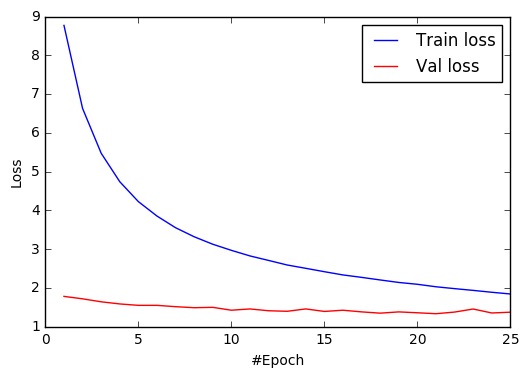

In [146]:
plot_validation_history(l2_his, './output/fig-nn-val-l2.png')


Training time: 320.011878 sec

Test loss: 1.306
Test accuracy: 0.537


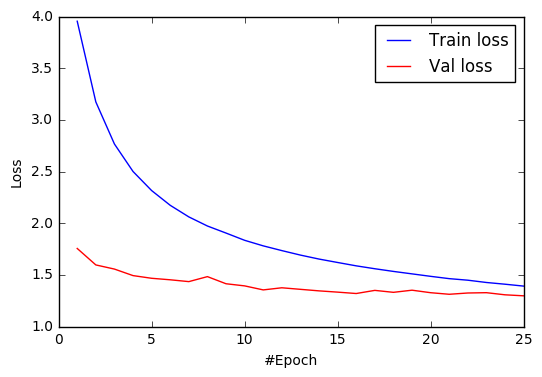

In [48]:
l2_model = gen_nn_2(l2_reg=True, l2_coef=0.001)
start = time.time()
l2_his = l2_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          callbacks=[early_stop],
          verbose=0, 
          shuffle=True) \

# evaluate our model
score = l2_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(l2_his, './output/fig-nn-val-l2-deep.png')

L2 is working, too!

# Maxout
Maxout is called maxout because its output is the max of a set of inputs. It wasa designed by Goodfellow on January 2013. 
You can simply create a dense layer with maxout by calling the MaxoutDense layer in Keras.
A MaxoutDense layer takes the element-wise maximum of nb_feature Dense(input_dim, output_dim) linear layers. This allows the layer to learn a convex, piecewise linear activation function over the inputs.
Given an input $v\subseteq\mathbb{R}^{d}$, a maxout hidden layer implements the function $h_{i}(x)=\underset{j\subseteq[1,k]}{max}z_{ij}$, where $z_{ij}=x^{T}W_{\text{···}ij}+b_{ij}$, and $W\subseteq\mathbb{R}^{d\times m\times k}$and $b\subseteq\mathbb{R}^{m\times k}$
<img src="fig-maxout.png" width="600">

In [49]:
maxout_model = gen_nn(maxout=True)
start = time.time()
maxout_his = maxout_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          callbacks=[early_stop],
          verbose=0, 
          shuffle=True) \

# evaluate our model
score = maxout_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(maxout_his, './output/fig-nn-val-maxout.png')

NameError: name 'gen_nn' is not defined

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 13s - loss: 1.8815 - acc: 0.3165 - val_loss: 1.7313 - val_acc: 0.3800
Epoch 2/25
40000/40000 [==============================] - 13s - loss: 1.6776 - acc: 0.3966 - val_loss: 1.5908 - val_acc: 0.4285
Epoch 3/25
40000/40000 [==============================] - 13s - loss: 1.5559 - acc: 0.4430 - val_loss: 1.5359 - val_acc: 0.4472
Epoch 4/25
40000/40000 [==============================] - 13s - loss: 1.4680 - acc: 0.4771 - val_loss: 1.4574 - val_acc: 0.4801
Epoch 5/25
40000/40000 [==============================] - 13s - loss: 1.4019 - acc: 0.5003 - val_loss: 1.4453 - val_acc: 0.4801
Epoch 6/25
40000/40000 [==============================] - 13s - loss: 1.3440 - acc: 0.5213 - val_loss: 1.4260 - val_acc: 0.4940
Epoch 7/25
40000/40000 [==============================] - 13s - loss: 1.2915 - acc: 0.5406 - val_loss: 1.3900 - val_acc: 0.5132
Epoch 8/25
40000/40000 [==============================

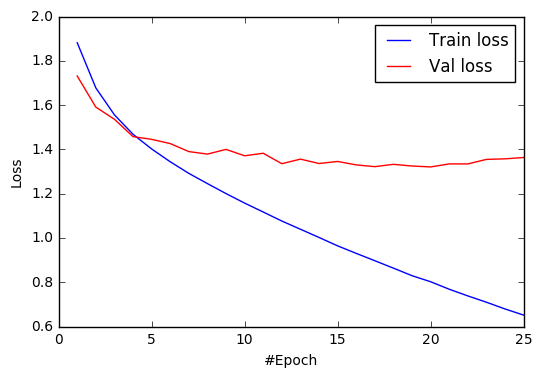

In [58]:
maxout_model = gen_nn_2(maxout=True)
start = time.time()
maxout_his = maxout_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          callbacks=[early_stop],
          verbose=1, 
          shuffle=True) \

# evaluate our model
score = maxout_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(maxout_his, './output/fig-nn-val-maxout.png')

# Batch Normalization
Batch Normalization is to explicitly forcing the activations throughout a network to take on a unit gaussian distribution. The core observation is that this is possible because normalization is a simple differentiable operation. In the implementation, insert the BatchNorm layer immediately after fully connected layers and before non-linearities.

- Improves gradient flow through the network
- Allows higher learning rates
- Reduces the strong dependence on initialization
- Acts as a form of regularization
<img src="fig-batch-normalization.png" width="600">

keras have implemented Batch Normalization for you.
```
keras.layers.normalization.BatchNormalization(mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one')
```

- mode: integer, 0, 1 or 2.

    - 0: feature-wise normalization. Each feature map in the input will be normalized separately. The axis on which to normalize is specified by the axis argument. Note that if the input is a 4D image tensor using Theano conventions (samples, channels, rows, cols) then you should set axis to 1 to normalize along the channels axis. During training we use per-batch statistics to normalize the data, and during testing we use running averages computed during the training phase.
    - 1: sample-wise normalization. This mode assumes a 2D input.
    - 2: feature-wise normalization, like mode 0, but using per-batch statistics to normalize the data during both testing and training.
    
- axis: integer, axis along which to normalize in mode 0.





Training time: 127.302012 sec

Test loss: 2.028
Test accuracy: 0.516


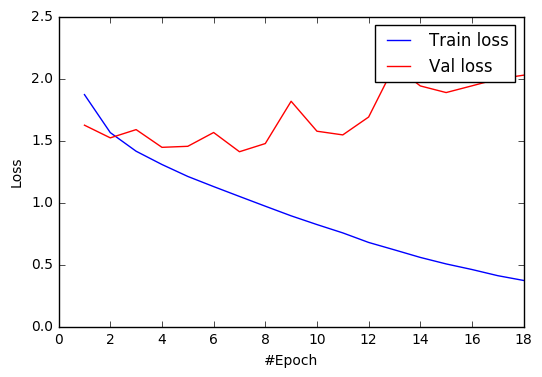

In [265]:
batch_norm_model = gen_nn(batch_normalization=True)
start = time.time()
batch_norm_his = batch_norm_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          callbacks=[early_stop],
          verbose=0, \
          shuffle=True) \
# evaluate our model
score = batch_norm_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(batch_norm_his, './output/fig-nn-val-batch_norm.png')


Training time: 145.034872 sec

Test loss: 1.586
Test accuracy: 0.505


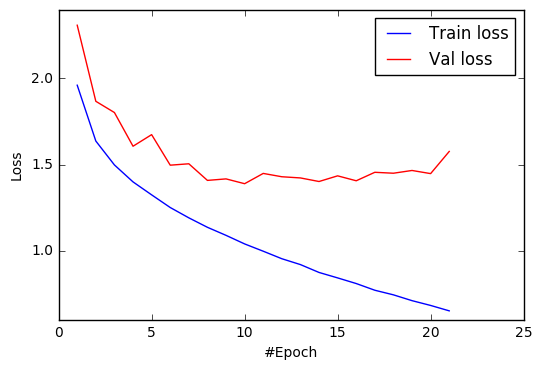

In [40]:
batch_norm_model = gen_nn_2(batch_normalization=True)
start = time.time()
batch_norm_his = batch_norm_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          callbacks=[early_stop],
          verbose=0, \
          shuffle=True) \
# evaluate our model
score = batch_norm_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(batch_norm_his, './output/fig-nn-val-batch_norm_deep.png')

# Noise
We can add noise to our data by data augmentation. We will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better. This skill is very useful especially when you have very little amount of data.
* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* shear_range is for randomly applying shearing transformations
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

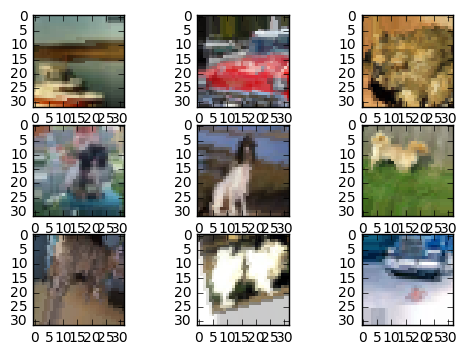

In [45]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as pyplot

datagen = ImageDataGenerator(
        rotation_range=20, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
# visualize some examples after augmentation
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        # transpose the image-channel to the third dimension for plotting img
        pyplot.imshow(X_batch[i].transpose(1,2,0), interpolation='nearest')
        # show the plot
    pyplot.show()
    break

In [175]:
base_model = gen_nn()    
start = time.time()
aug_his = base_model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=batch_size),
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=nb_epoch,
                    callbacks=[early_stop],
                    verbose=0, 
                    validation_data=(X_valid, y_valid))
# evaluate our model
score = base_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])


Training time: 293.670145 sec

Test loss: 1.418
Test accuracy: 0.492


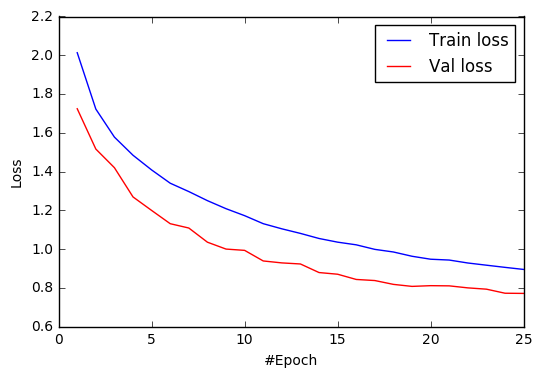

In [48]:
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

Now you've learned lots of techniques and layers to improve your model, good luck training!

In [46]:
base_model = gen_nn_2()    
start = time.time()
aug_his = base_model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=batch_size),
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=nb_epoch,
                    callbacks=[early_stop],
                    verbose=0, 
                    validation_data=(X_valid, y_valid))
# evaluate our model
score = base_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])


Training time: 316.740645 sec

Test loss: 1.433
Test accuracy: 0.495


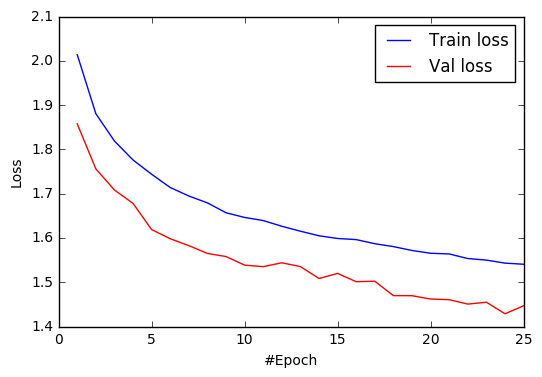

In [47]:
plot_validation_history(aug_his, './output/fig-nn-val-aug-deep.png')